# Objective

Demo and explore the performance of scikit-image's blob_dog() (difference of Gaussians) blob finding algorithm with normxcorr2 pre-processing, downsampling, bubble detection, and separate intensity thresholds for images with and without bubbles.

# Images used

71 raw images (cropped, not pre-rescaled) were used to find linear transformation parameters. The same images were also used to find blob_dog() intensity thresholds for images with and without bubbles, using `benchmark_blob_dog_find_thresh_w_normxcorr2.ipynb`.

14 new raw images (cropped, not pre-rescaled, 7 with bubbles and 7 without bubbles) are used to determine whether the linear transformation and intensity threshold parameters found using the 71 images

# Preprocessing

normxcorr2 (from https://github.com/czbiohub/cell-counting-imager/blob/828b8af950beb32ff76548f11764c8915bb9b6d6/cell_counting_imager/normxcorr2.py)

downsampling (from https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.downscale_local_mean)

# Results

The first plot shows count predicted vs. count ground truth. For this whole notebook, count predicted comes from difference of gaussians after images have been filtered by normxcorr2, which I call in this notebook. The green line shows y = x, that is predicted count = gt count. The gray line is the linear regression of the data. I found the best intensity thresholds for images with and without bubbles in a separate notebook; this plot doesn’t differentiate between images with and without bubbles. The best intensity thresholds yield an R^2 of 0.95.

The second plot does differentiate between images with and without bubbles, and uses a different intensity threshold for each. R^2 has improved to 0.96.

And the third plot shows the linear transformation. So you can see that thanks to the normxcorr2 filter, the data is a lot tighter because a lot fewer cells fade into the background unpredictably.

In the fourth plot, I’ve added the 14 new test images with and without bubbles, subjected to the same intensity thresholds and linear transformation parameters as the original 71 images. R^2 is still 0.96, and the bubble and non bubble images are for the most part not too far from the line.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from normxcorr2 import normxcorr2
from skimage.feature import blob_dog
from skimage.io import imread
from skimage import exposure, transform
from scipy.stats import linregress
from matplotlib.lines import Line2D
import warnings, math
warnings.filterwarnings('ignore')

In [2]:
def cross_correlate(im):
    im_normxcorr2 = normxcorr2(kernel, im)
    lr_edge = (im_normxcorr2.shape[0] - im.shape[0])/2
    ud_edge = (im_normxcorr2.shape[1] - im.shape[1])/2
    return im_normxcorr2[int(ud_edge):int(ud_edge*-1), int(ud_edge):int(ud_edge*-1)]

In [3]:
# using default kernel params
kernelSize = 150
ds = 2 # down-sampling integer factor along each axis
discRadius = 3

In [4]:
# set up kernel
kernel = np.zeros((kernelSize, kernelSize), 'uint16')
kernelCtr = kernelSize/2
for rr in range(0, kernelSize + 1):
    for cc in range(0, kernelSize + 1):
        if  math.sqrt((rr - kernelCtr)**2 + (cc - kernelCtr)**2) < discRadius:
            kernel[rr, cc] = 65535
kernel = transform.downscale_local_mean(kernel, (ds,ds))

# Test all 71 images

In [5]:
names_raw = pd.read_csv('names.csv', header=None)
names = [x[0][23:-4] for x in names_raw.values]

In [6]:
names_raw = pd.read_csv('names_test.csv', header=None)
names_test = [x[0][14:] for x in names_raw.values]

In [7]:
bubble_image_names = [
    '20200901-193536-2',
    '20200916-192532-4',
    '20201002-131101-4'
]

In [8]:
bubble_image_names_test = [
    '20201217-142717-5',
    '20201217-142717-2',
    '20201217-142717-0',
    '20201216-163816-1',
    '20201216-141203-7',
    '20201216-135719-5',
    '20201216-135719-2'
]

In [9]:
# bubble detection parameters
n = 12
l = 256

threshold = 0.1

In [10]:
gt_counts, pred_counts, colors = [], [], []
for i in range(len(names)):
    if i%10==0:
        print(i, '/', len(names))
    name = names[i]
    im = imread('raw_images_cropped/image-cropped-%s.tif' % name)
    im = cross_correlate(im)
    df = pd.read_csv('./all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)
    blobs = blob_dog(im, min_sigma=5, max_sigma=15, threshold=0.1)
    gt_counts.append(len(df))
    pred_counts.append(len(blobs))
    if name in bubble_image_names:
        colors.append('m')
    else:
        colors.append('c')

0 / 71
10 / 71
20 / 71
30 / 71
40 / 71
50 / 71
60 / 71
70 / 71


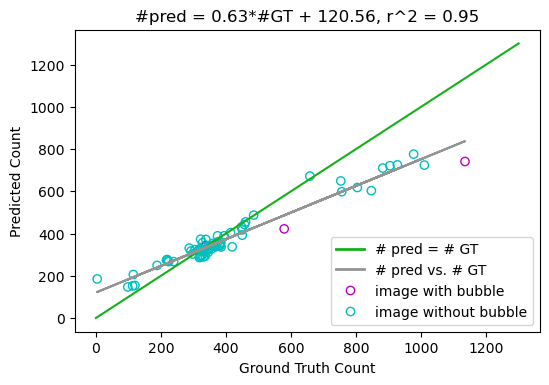

In [11]:
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(gt_counts, pred_counts, facecolor='None', edgecolor=colors)
plt.plot([0, 1300], [0, 1300], color='xkcd:green')
plt.xlabel('Ground Truth Count')
plt.ylabel('Predicted Count')

slope, intercept, r_value, p_value, std_err = linregress(gt_counts, pred_counts)
plt.plot(gt_counts, intercept + [slope*x for x in gt_counts], color='xkcd:gray')
plt.title('#pred = %s*#GT + %s, r^2 = %s' % (str(round(slope,2)), str(round(intercept,2)), str(round(r_value**2,2))))

handle_list = []
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:green', lw=2, label='# pred = # GT'))
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:gray', lw=2, label='# pred vs. # GT'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='m', label='image with bubble'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='c', label='image without bubble'))
plt.legend(handles=handle_list, loc='lower right', fontsize=10)

plt.show()

### Using a different intensity threshold for images with bubbles
threshold = 0.1

threshold for bubble image = 0.08

In [12]:
gt_counts, pred_counts, colors = [], [], []
for i in range(len(names)):
    if i%10==0:
        print(i, '/', len(names))
    name = names[i]
    im = imread('raw_images_cropped/image-cropped-%s.tif' % name)
    im = cross_correlate(im)
    df = pd.read_csv('./all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)
    if name in bubble_image_names:
        colors.append('m')
        threshold=0.08
    else:
        colors.append('c')
        threshold=0.1
    blobs = blob_dog(im, min_sigma=5, max_sigma=15, threshold=threshold)
    gt_counts.append(len(df))
    pred_counts.append(len(blobs))

0 / 71
10 / 71
20 / 71
30 / 71
40 / 71
50 / 71
60 / 71
70 / 71


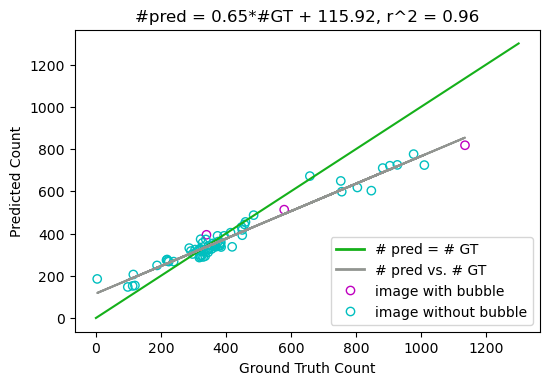

In [13]:
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(gt_counts, pred_counts, facecolor='None', edgecolor=colors)
plt.plot([0, 1300], [0, 1300], color='xkcd:green')
plt.xlabel('Ground Truth Count')
plt.ylabel('Predicted Count')

slope, intercept, r_value, p_value, std_err = linregress(gt_counts, pred_counts)
plt.plot(gt_counts, intercept + [slope*x for x in gt_counts], color='xkcd:gray')
plt.title('#pred = %s*#GT + %s, r^2 = %s' % (str(round(slope,2)), str(round(intercept,2)), str(round(r_value**2,2))))

handle_list = []
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:green', lw=2, label='# pred = # GT'))
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:gray', lw=2, label='# pred vs. # GT'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='m', label='image with bubble'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='c', label='image without bubble'))
plt.legend(handles=handle_list, loc='lower right', fontsize=10)

plt.show()

### Using a different intensity threshold for images with bubbles and with linear transformation

In [14]:
# from above, with bubble detection and without linear transformation
slope_use, intercept_use = slope, intercept

In [15]:
from datetime import datetime

In [17]:
print(datetime.now())
gt_counts, pred_counts, colors = [], [], []
for i in range(len(names)):
    if i%10==0:
        print(i, '/', len(names))
    name = names[i]
    im = imread('raw_images_cropped/image-cropped-%s.tif' % name)
    im = cross_correlate(im)
    df = pd.read_csv('./all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)
    if name in bubble_image_names:
        colors.append('m')
        threshold = 0.08
    else:
        colors.append('c')
        threshold = 0.1
    blobs = blob_dog(im, min_sigma=5, max_sigma=15, threshold=threshold)
    gt_counts.append(len(df))
    count_blobs_raw = len(blobs)
    count_blobs = (count_blobs_raw - intercept_use)/slope_use
    pred_counts.append(count_blobs)
print(datetime.now())

2021-02-27 00:13:11.275902
0 / 71
10 / 71
20 / 71
30 / 71
40 / 71
50 / 71
60 / 71
70 / 71
2021-02-27 00:14:21.854581


^ 0.994 seconds each image

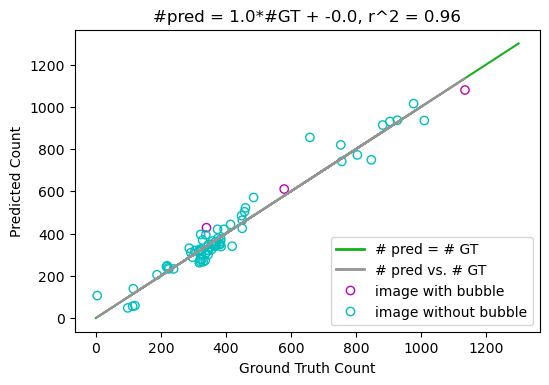

In [18]:
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(gt_counts, pred_counts, facecolor='None', edgecolor=colors)
plt.plot([0, 1300], [0, 1300], color='xkcd:green')
plt.xlabel('Ground Truth Count')
plt.ylabel('Predicted Count')

slope, intercept, r_value, p_value, std_err = linregress(gt_counts, pred_counts)
plt.plot(gt_counts, intercept + [slope*x for x in gt_counts], color='xkcd:gray')
plt.title('#pred = %s*#GT + %s, r^2 = %s' % (str(round(slope,2)), str(round(intercept,2)), str(round(r_value**2,2))))

handle_list = []
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:green', lw=2, label='# pred = # GT'))
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:gray', lw=2, label='# pred vs. # GT'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='m', label='image with bubble'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='c', label='image without bubble'))
plt.legend(handles=handle_list, loc='lower right', fontsize=10)

plt.show()

# Add new test images

In [19]:
pred_counts_plus = pred_counts
gt_counts_plus = gt_counts
colors_plus = colors
print(datetime.now())
for i in range(len(names_test)):
    print('test', i, '/', len(names_test))
    name = names_test[i]
    im = imread('./test_new/images/image-cropped-image-%s.tif' % name)
    im = cross_correlate(im)
    df = pd.read_csv('./test_new/gt/image-cropped-%s_gt.csv' % name)
    if name in bubble_image_names_test:
        colors_plus.append('r')
        threshold = 0.08
    else:
        colors_plus.append('b')
        threshold = 0.1
    blobs = blob_dog(im, min_sigma=5, max_sigma=15, threshold=threshold)
    gt_counts_plus.append(len(df))
    count_blobs_raw = len(blobs)
    count_blobs = (count_blobs_raw - intercept_use)/slope_use
    pred_counts_plus.append(count_blobs)
print(datetime.now())

2021-02-27 00:14:21.996512
test 0 / 14
test 1 / 14
test 2 / 14
test 3 / 14
test 4 / 14
test 5 / 14
test 6 / 14
test 7 / 14
test 8 / 14
test 9 / 14
test 10 / 14
test 11 / 14
test 12 / 14
test 13 / 14
2021-02-27 00:14:36.293779


^ 1.02 seconds each image

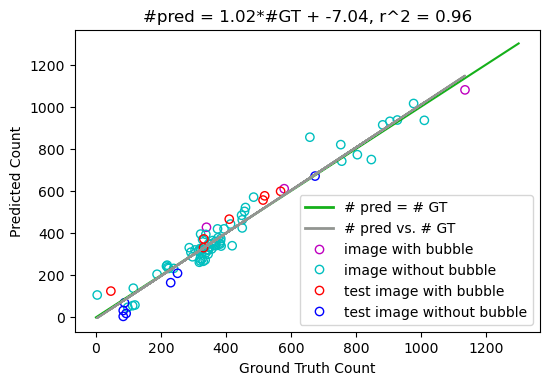

In [20]:
plt.figure(figsize=(6,4), dpi=100)
plt.scatter(gt_counts_plus, pred_counts_plus, facecolor='None', edgecolor=colors_plus)
plt.plot([0, 1300], [0, 1300], color='xkcd:green')
plt.xlabel('Ground Truth Count')
plt.ylabel('Predicted Count')

slope, intercept, r_value, p_value, std_err = linregress(gt_counts_plus, pred_counts_plus)
plt.plot(gt_counts_plus, intercept + [slope*x for x in gt_counts_plus], color='xkcd:gray')
plt.title('#pred = %s*#GT + %s, r^2 = %s' % (str(round(slope,2)), str(round(intercept,2)), str(round(r_value**2,2))))

handle_list = []
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:green', lw=2, label='# pred = # GT'))
handle_list.append(Line2D([0],[0], marker=None, color='xkcd:gray', lw=2, label='# pred vs. # GT'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='m', label='image with bubble'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='c', label='image without bubble'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='r', label='test image with bubble'))
handle_list.append(Line2D([0],[0], marker='o', color='None',
                          markerfacecolor='None', markeredgecolor='b', label='test image without bubble'))

plt.legend(handles=handle_list, loc='lower right', fontsize=10)

plt.show()

blob_dog() is 4 times faster than blob_log(). Using separate intensity thresholds for images with and without bubbles, and linear transforming the results (using slope and y-intercept from results without bubble detection), predicted counts vs. ground truth counts has a regression line with a slope of 1, a y-intercept of 0, and an r^2 of 0.96.

# Sandbox

## Check one image

In [58]:
df = pd.DataFrame()
df['name'] = names
df['pred_count'] = pred_counts
df['gt_count'] = gt_counts
df['color'] = colors

In [60]:
df[df.pred_count>800][df.pred_count<900][df.gt_count>600][df.gt_count<700]

,name,pred_count,gt_count,color
21,20200916-200538-0,855.130408,658,c


In [39]:
name = list(df[df.pred_count>800][df.pred_count<900][df.gt_count>600][df.gt_count<700].name)[0]

In [62]:
name

'20200916-200538-0'

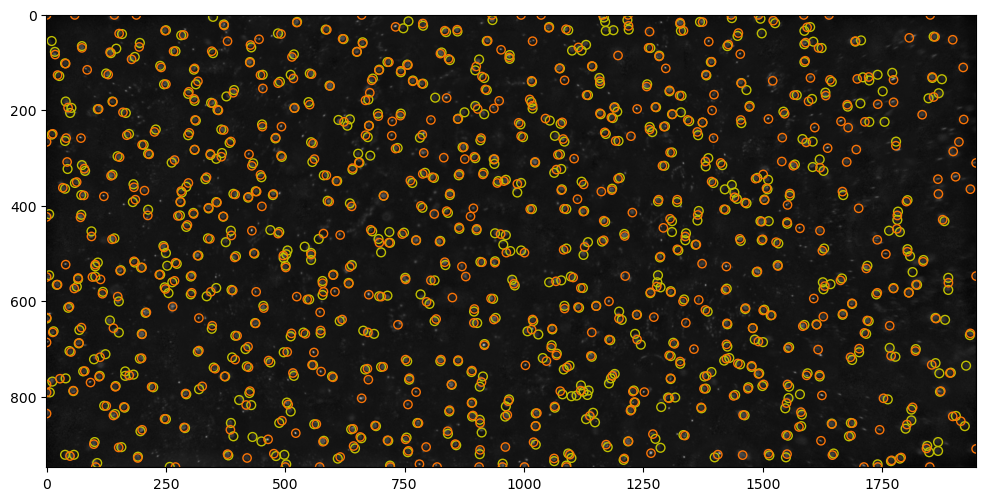

In [61]:
plt.figure(figsize=(12,6), dpi=100)
im = imread('raw_images_cropped/image-cropped-%s.tif' % name)
im = cross_correlate(im)
blobs = blob_dog(im, min_sigma=5, max_sigma=15, threshold=0.1)
plt.imshow(im, cmap='gray')
df = pd.read_csv('./all_test_gt_complete/image-cropped-rescaled-%s.csv' % name)
plt.scatter(df.X, df.Y, s=40, facecolor='None', edgecolor='y')
plt.scatter(blobs[:,1], blobs[:,0], facecolor='None', edgecolor='xkcd:orange')
plt.show()

In [63]:
len(blobs)

672

In [64]:
len(df)

658

## Test im_normxcorr2

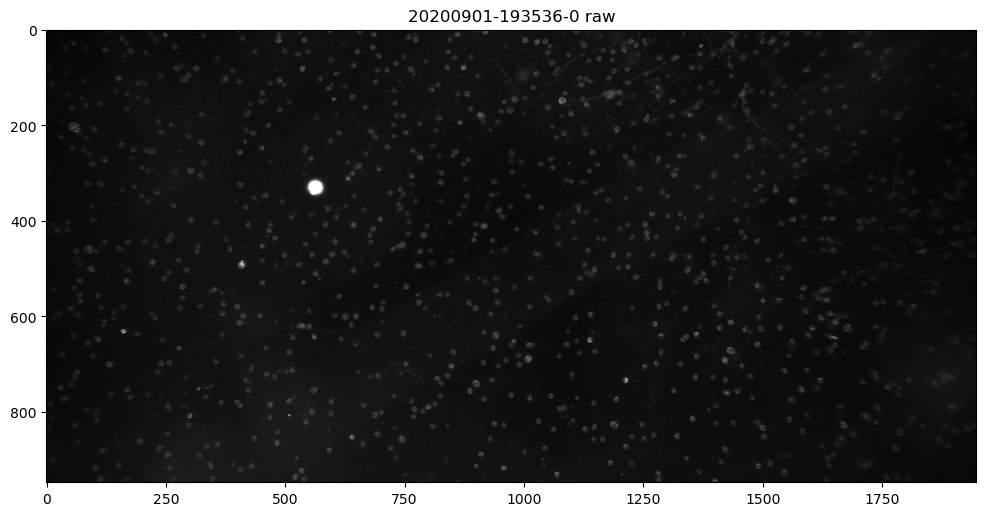

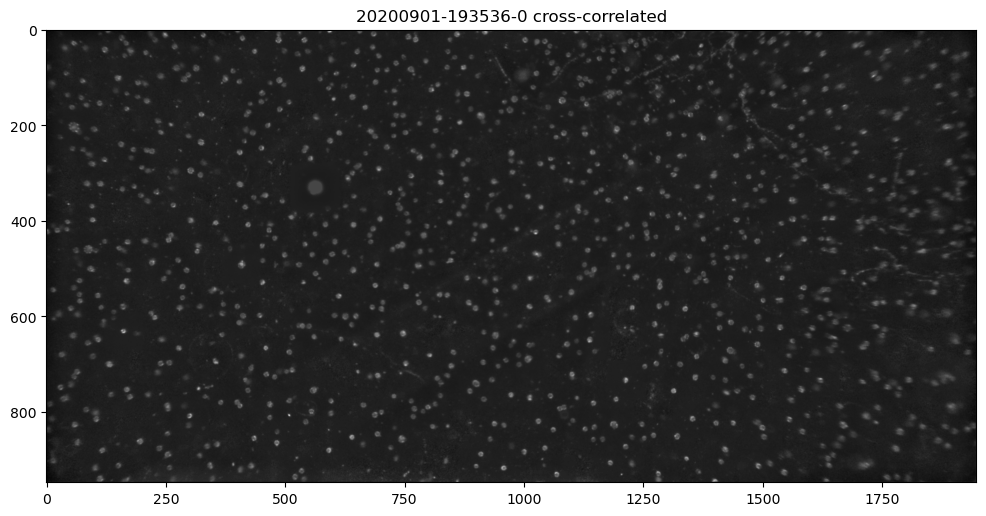

In [20]:
im = imread('raw_images_cropped/image-cropped-%s.tif' % names[0])
im_normxcorr2 = cross_correlate(im)
plt.figure(figsize=(12,6), dpi=100)
plt.imshow(im, cmap='gray')
plt.title(names[0] + ' raw')
plt.show()
plt.figure(figsize=(12,6), dpi=100)
plt.imshow(im_normxcorr2, cmap='gray')
plt.title(names[0] + ' cross-correlated')
plt.show()